In [509]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [510]:
df_1 = pd.read_csv('/Users/jack/time_series_covid19_confirmed_global.csv')

In [511]:
#italia = df.loc[df1['Country/Region'] == "Italy"]

In [512]:
df_1 = df_1.iloc[:, 4:]
df_1.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,0,0,0,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,0,0,0,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,0,0,0,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,0,0,0,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,0,0,0,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [513]:
casi_giorno = df_1.sum(axis=0)

In [514]:
casi_giorno.head()

1/22/20     555
1/23/20     654
1/24/20     941
1/25/20    1434
1/26/20    2118
dtype: int64

In [517]:
casi_giorno.index = pd.to_datetime(casi_giorno.index)

In [518]:
casi_giorno.tail()

2020-03-29     720117
2020-03-30     782365
2020-03-31     857487
2020-04-01     932605
2020-04-02    1013157
dtype: int64

Text(0.5, 1.0, 'Casi totali ITALIA')

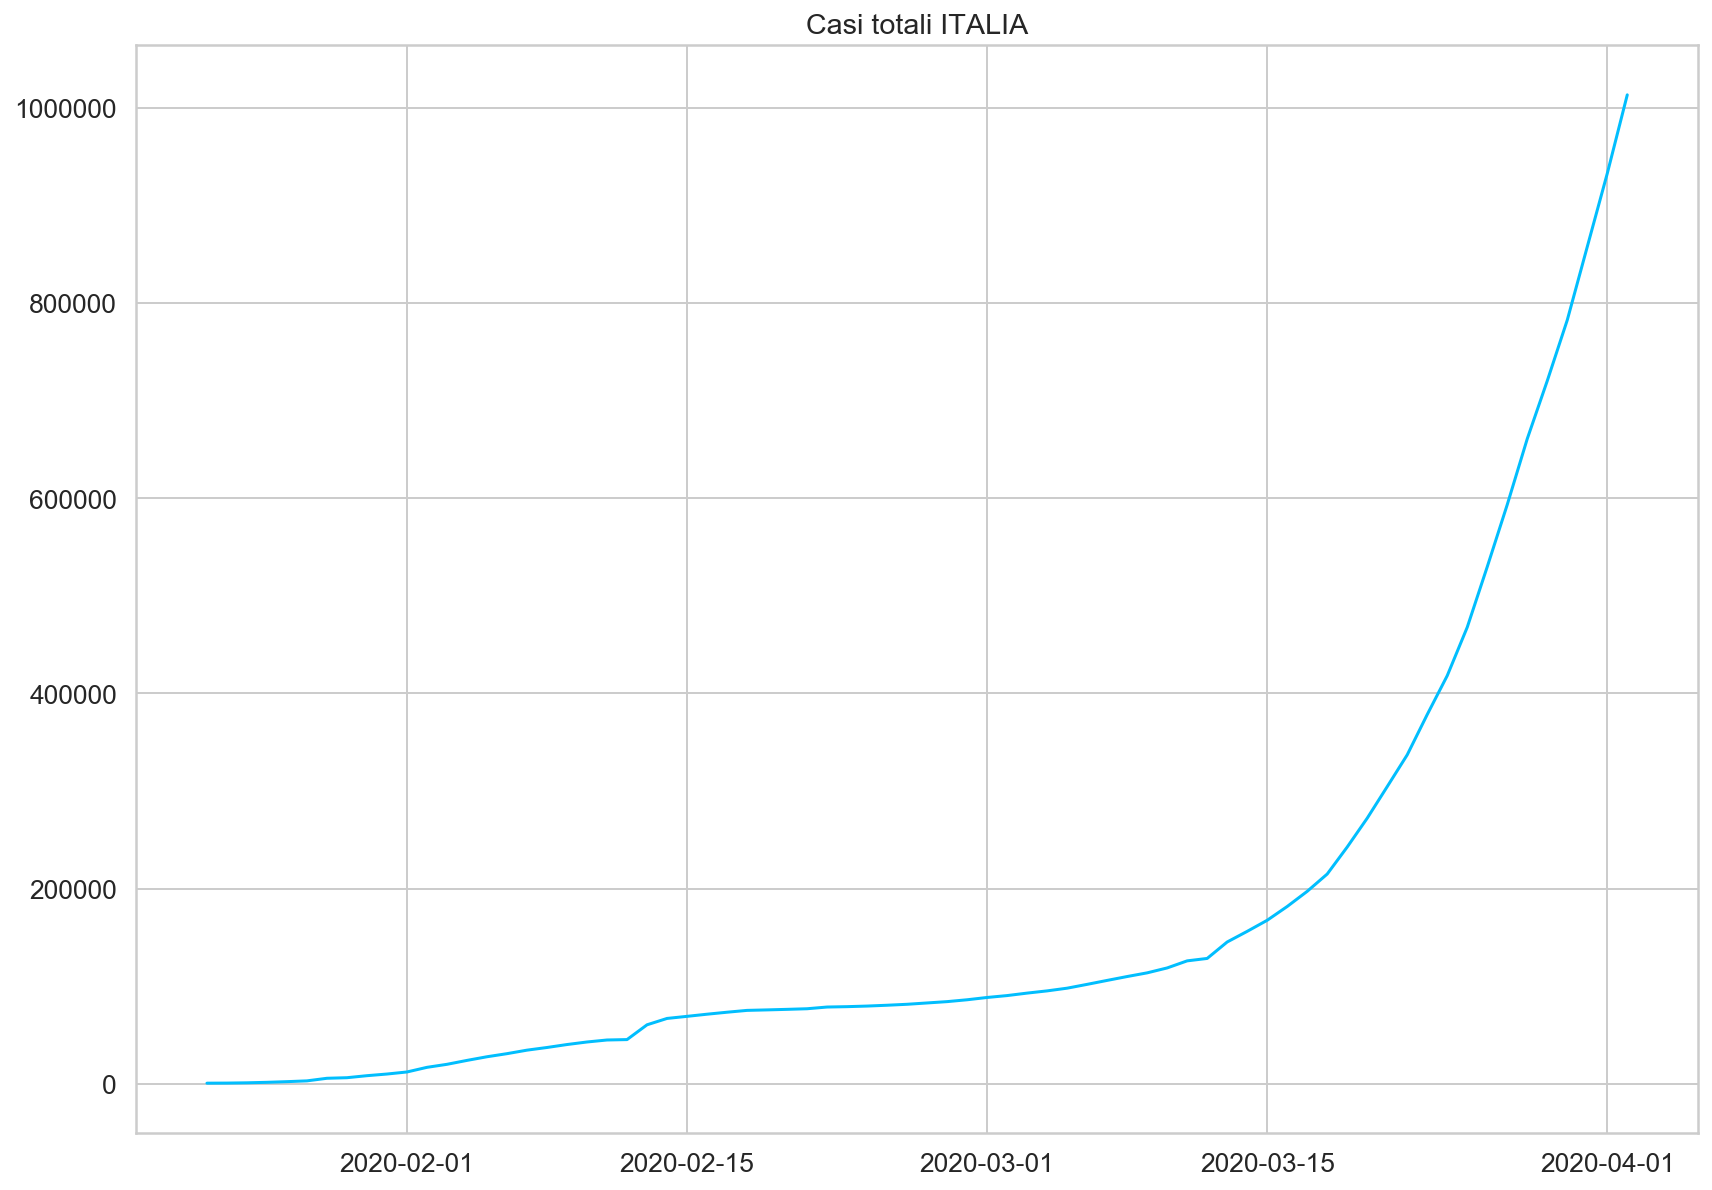

In [519]:
plt.plot(casi_giorno)
plt.title("Casi totali ITALIA")

In [536]:
casi_giorno = casi_giorno.diff().fillna(casi_giorno[0]).astype(np.int64)
casi_giorno.head()

2020-01-22     555
2020-01-23   -1011
2020-01-24     644
2020-01-25      18
2020-01-26     -15
dtype: int64

Text(0.5, 1.0, 'Nuovi casi ITALIA')

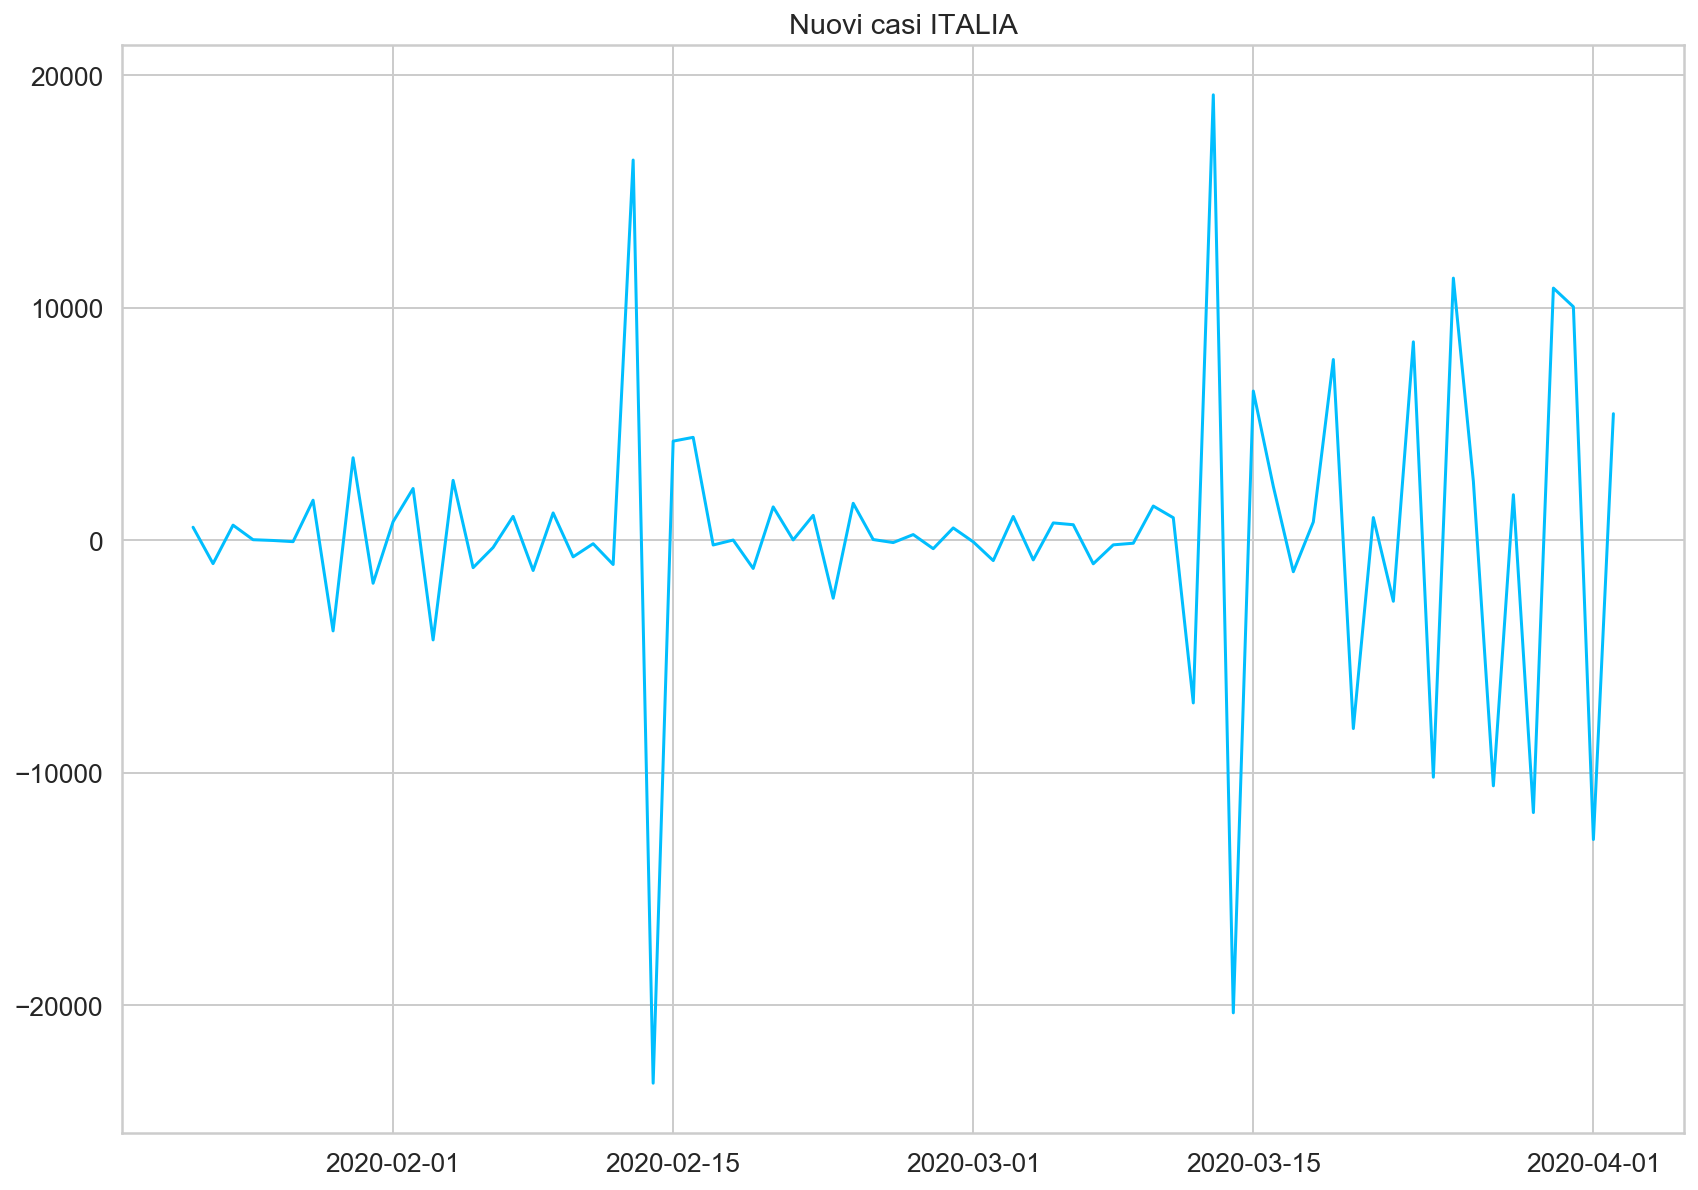

In [537]:
plt.plot(casi_giorno)
plt.title("Nuovi casi ITALIA")

In [538]:
casi_giorno.shape

(72,)

In [539]:
test_data_size = 31

traing_data = casi_giorno[:-test_data_size]
test_data = casi_giorno[-test_data_size:]

In [540]:
traing_data.shape

(41,)

In [541]:
test_data.shape

(31,)

Scalo i dati

In [542]:
scala = MinMaxScaler()

In [543]:
scala = scala.fit(np.expand_dims(traing_data, axis=1))

traing_data = scala.transform(np.expand_dims(traing_data, axis=1))
test_data = scala.transform(np.expand_dims(test_data, axis=1))

In [544]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [545]:
seq_length = 5

X_train, y_train = create_sequences(traing_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [546]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    
    return y_pred

In [547]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [548]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 13.491218566894531 test loss: 10.455639839172363
Epoch 10 train loss: 1.018104910850525 test loss: 1.562498688697815
Epoch 20 train loss: 0.8182365894317627 test loss: 1.421510100364685
Epoch 30 train loss: 0.6588578224182129 test loss: 1.255531907081604
Epoch 40 train loss: 0.5939050912857056 test loss: 1.2453340291976929
Epoch 50 train loss: 0.600700318813324 test loss: 1.2635000944137573


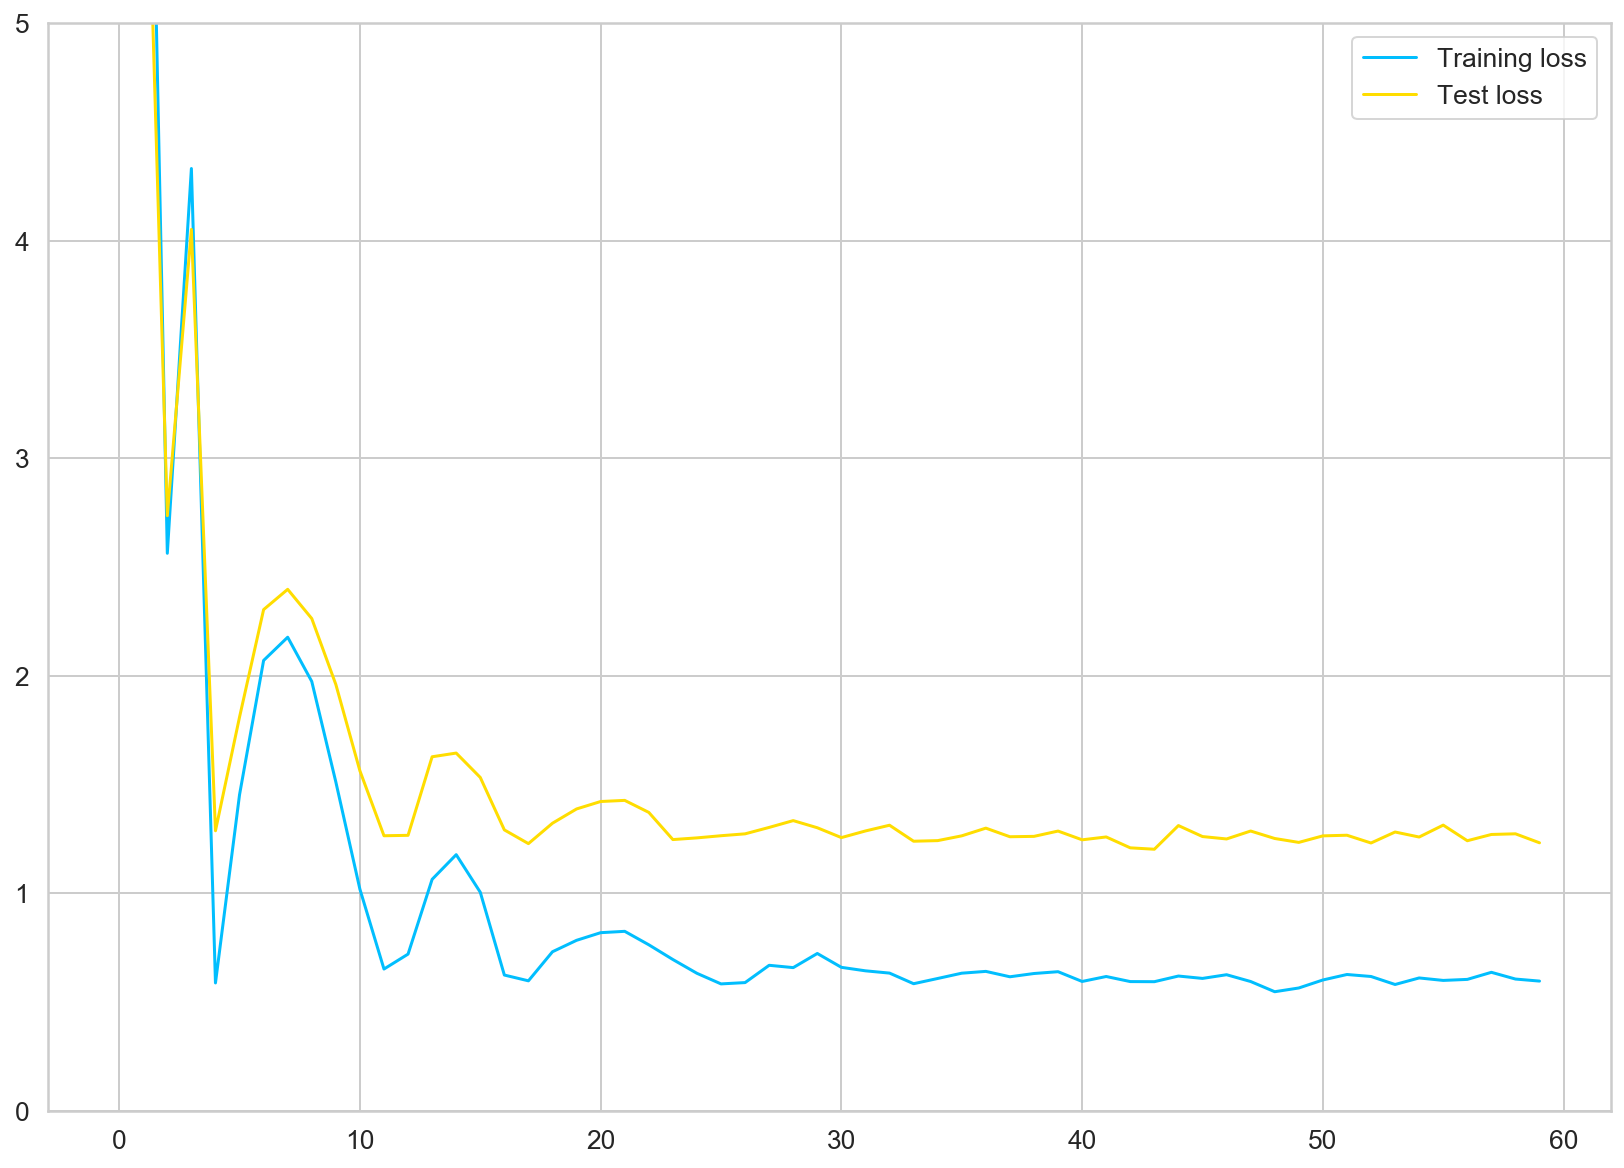

In [549]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [550]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [551]:
true_cases = scala.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scala.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

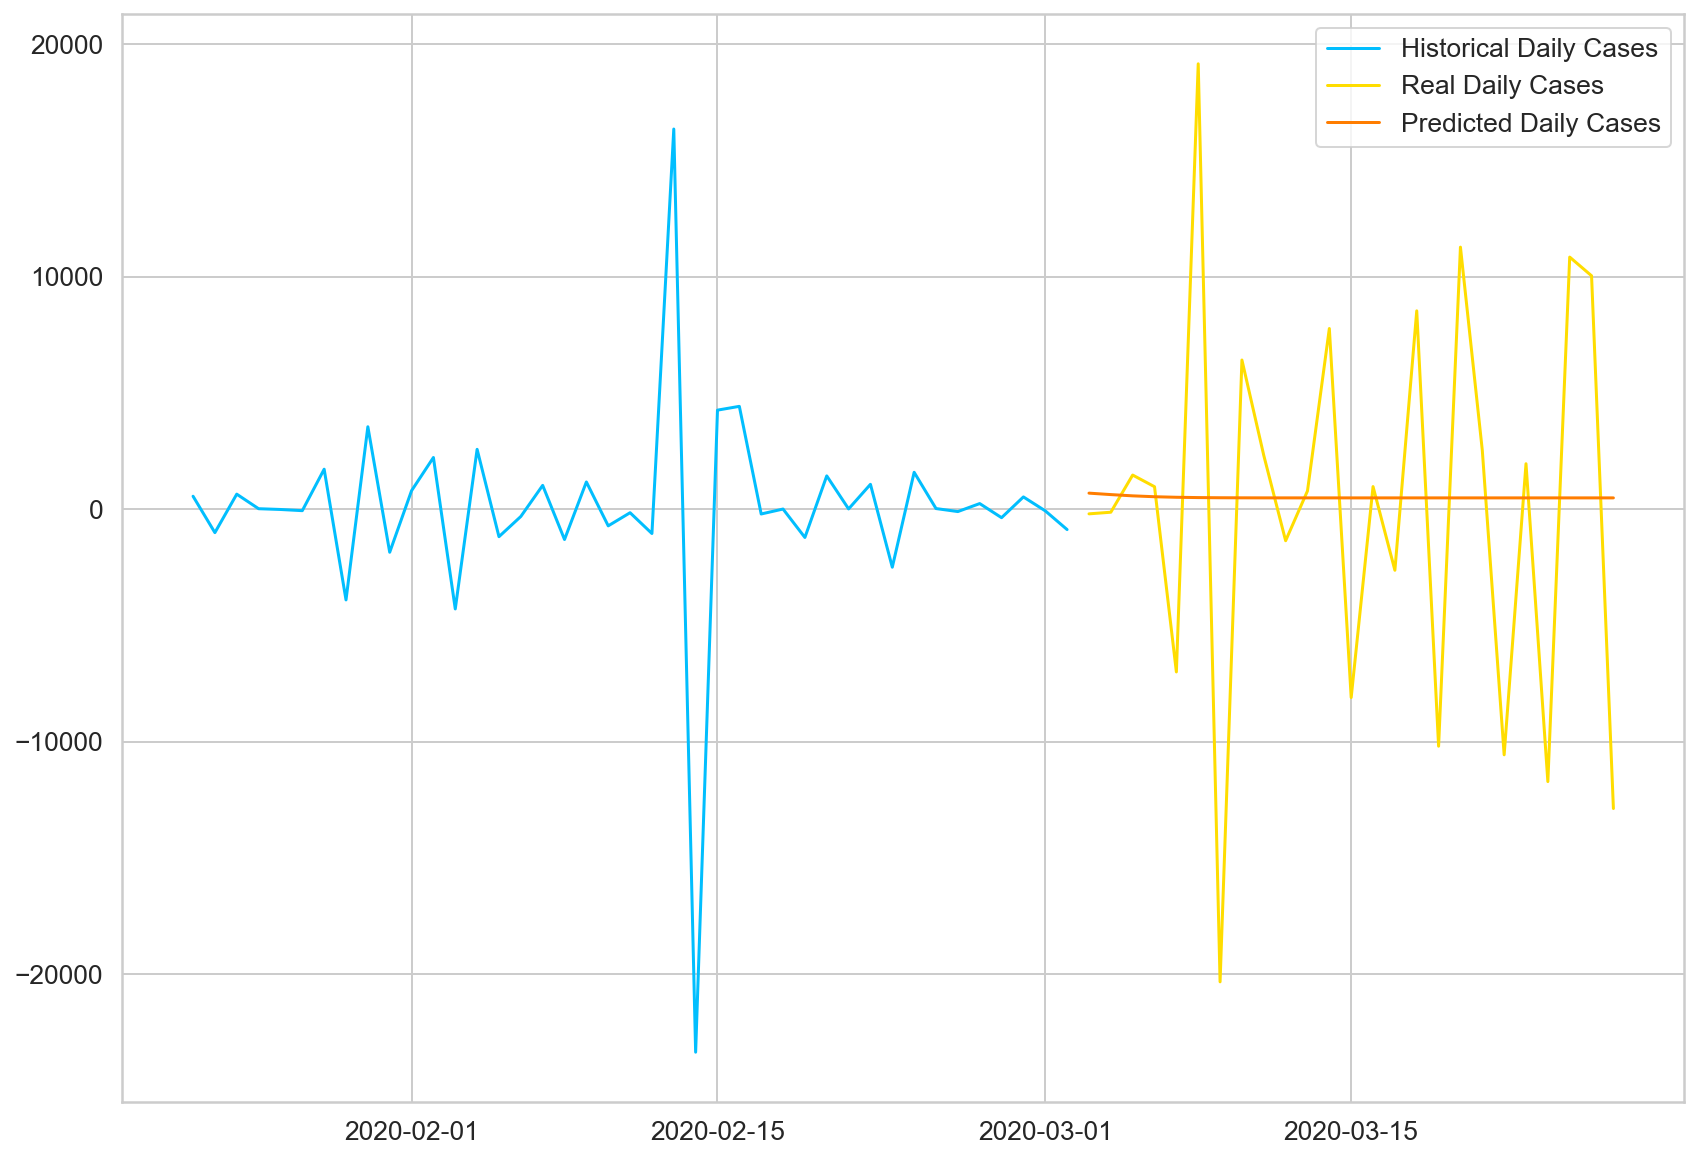

In [552]:
plt.plot(
  casi_giorno.index[:len(traing_data)], 
  scala.inverse_transform(traing_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  casi_giorno.index[len(traing_data):len(traing_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  casi_giorno.index[len(traing_data):len(traing_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend()

In [553]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(casi_giorno, axis=1))

all_data = scaler.transform(np.expand_dims(casi_giorno, axis=1))

all_data.shape

(72, 1)

In [554]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 14.763986587524414
Epoch 10 train loss: 0.7857664227485657
Epoch 20 train loss: 0.6942580938339233
Epoch 30 train loss: 0.6402192115783691
Epoch 40 train loss: 0.6022918820381165
Epoch 50 train loss: 0.5753488540649414


In [564]:
DAYS_TO_PREDICT = 10

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [565]:
predicted_cases = scala.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [566]:
casi_giorno.index[-1]

Timestamp('2020-04-02 00:00:00')

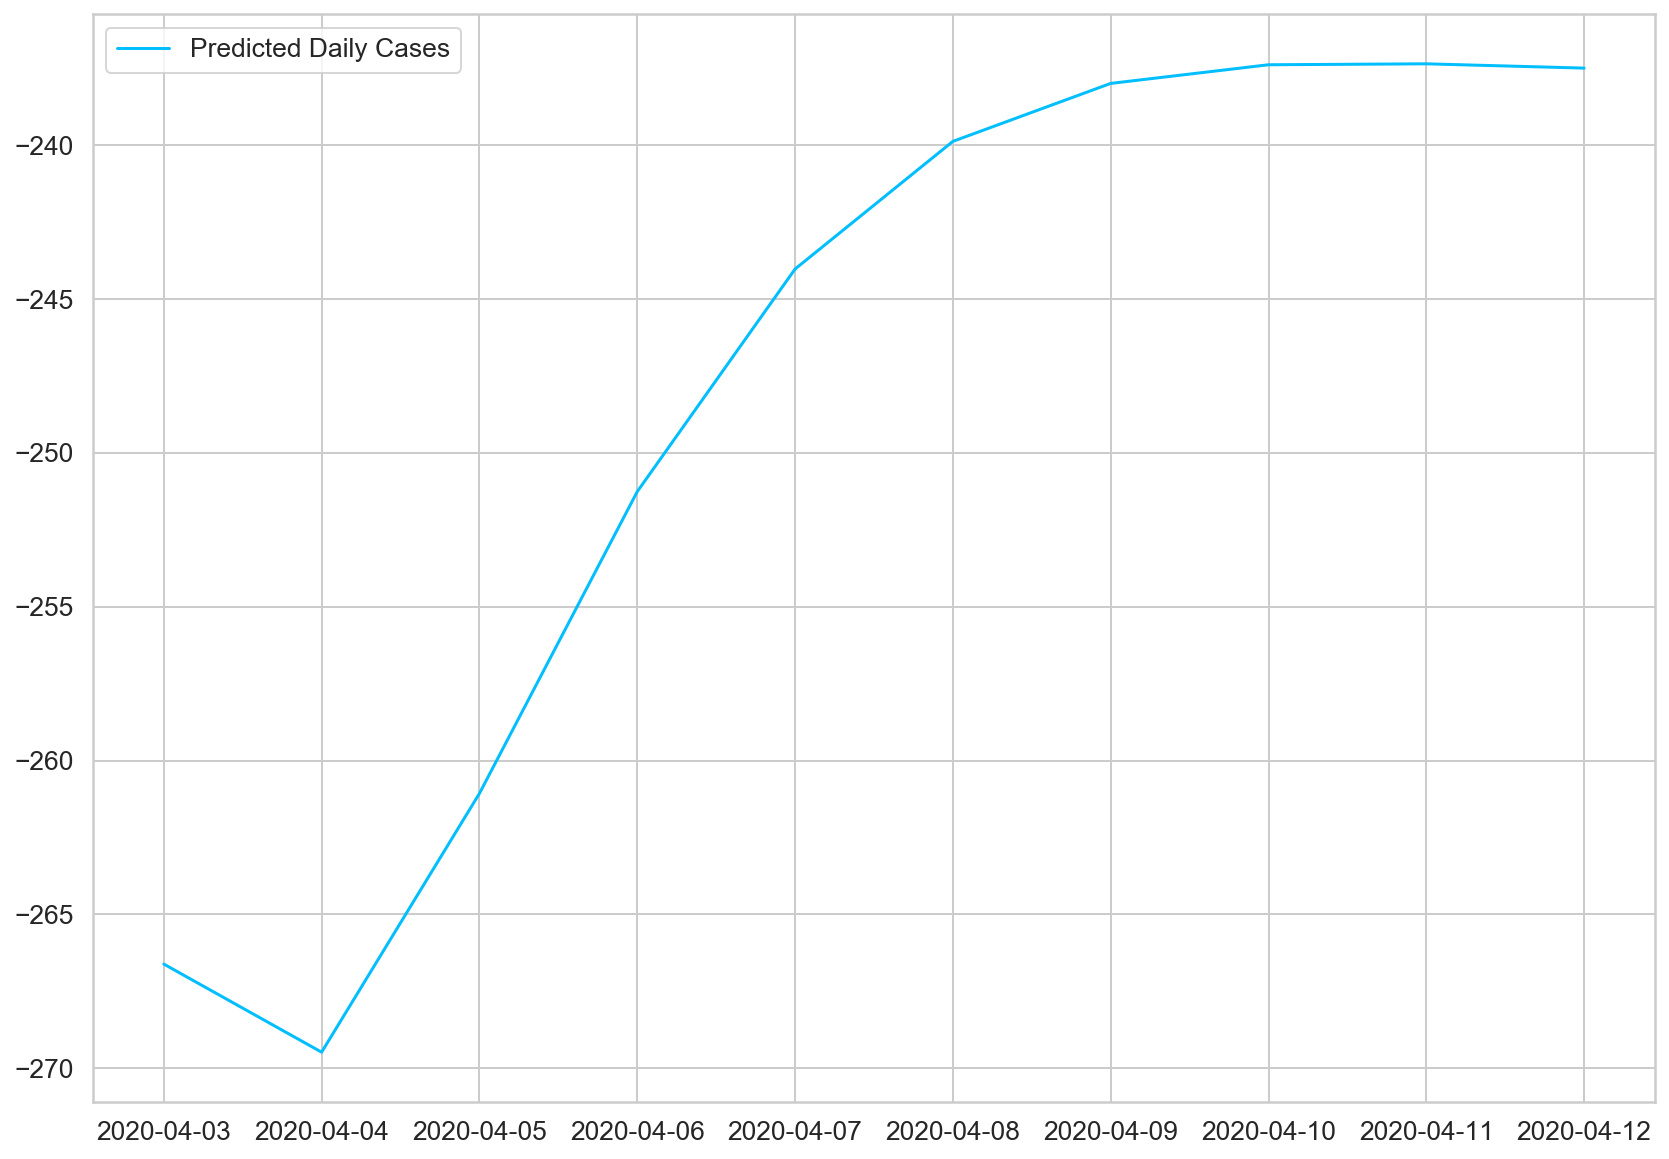

In [567]:
predicted_index = pd.date_range(
  start=casi_giorno.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

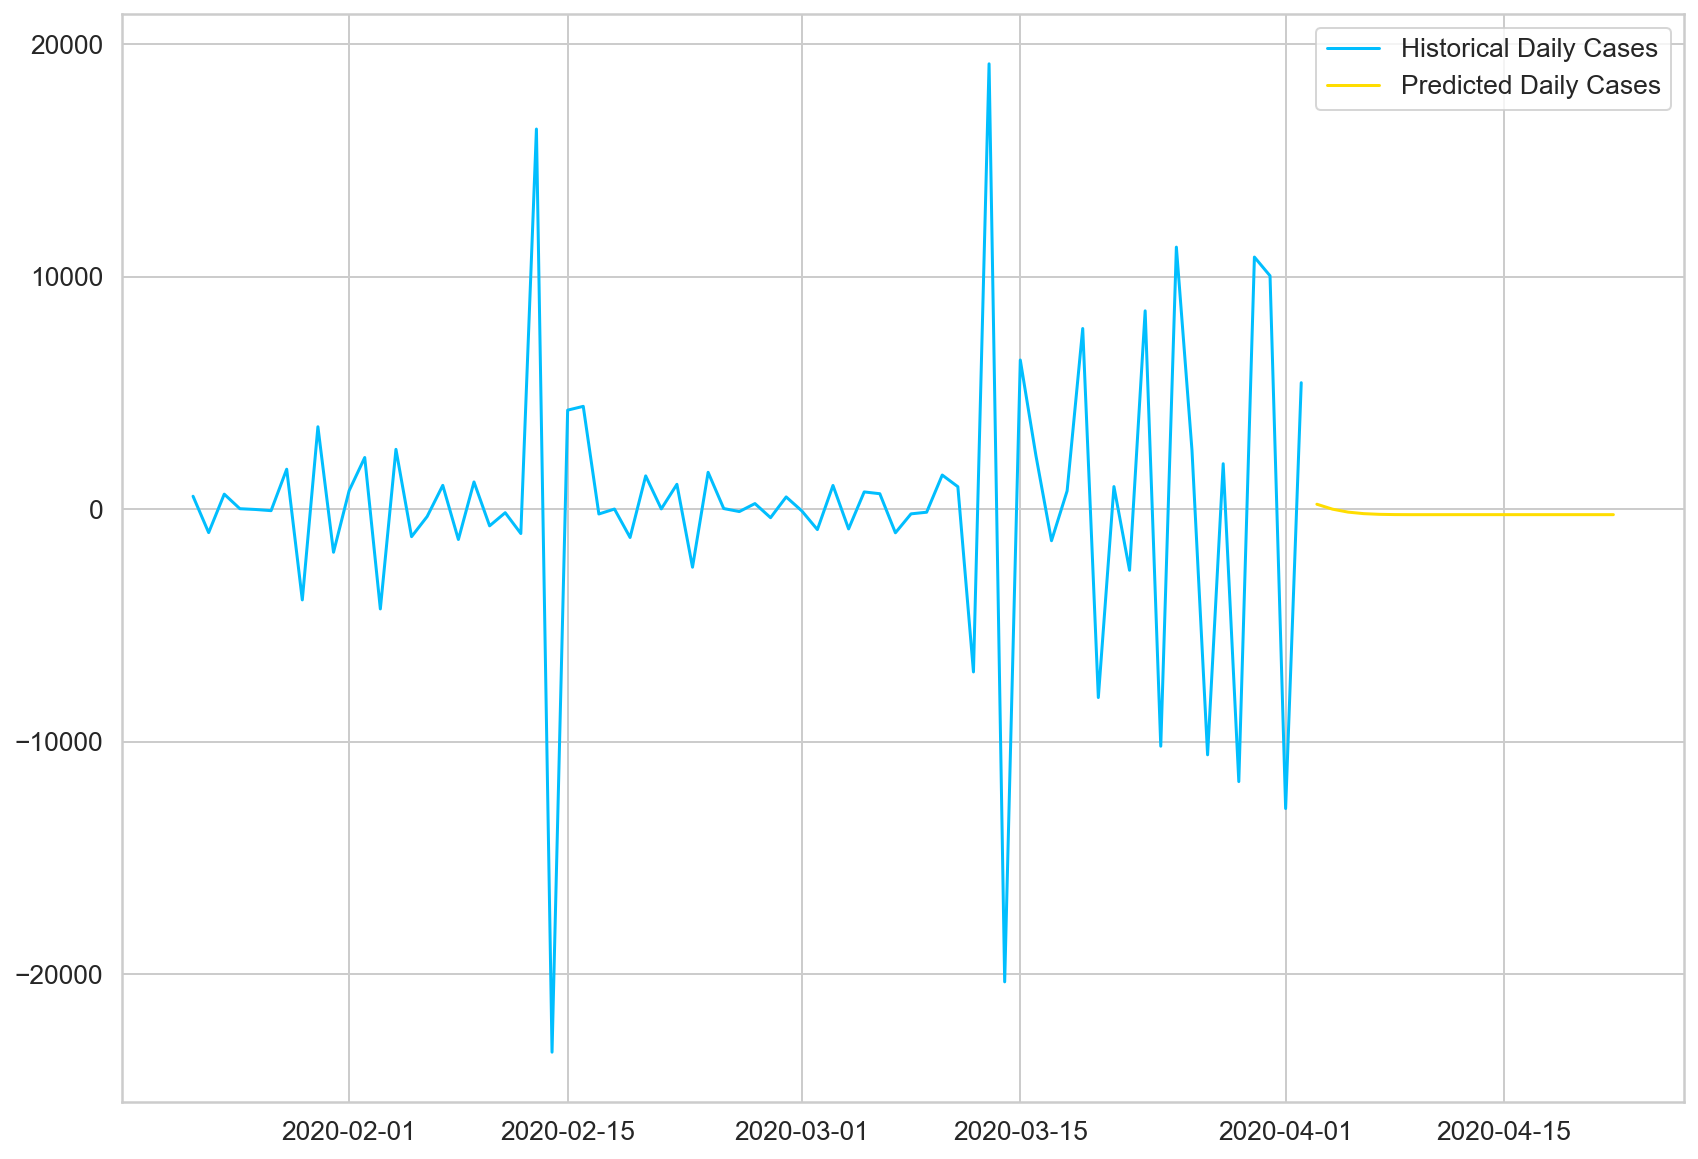

In [563]:
plt.plot(casi_giorno, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();